<a href="https://colab.research.google.com/github/pibieta/ML-course/blob/master/Serasa_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Taxi Fare 
---
J. P. Ibieta-Jimenez


In [0]:
# imports
import time
import random
import itertools
import datetime as dt
import pickle
from math import cos, asin, sqrt

# data handling and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')

# Geopy
import geopy as gp

We will work on the Kaggle competition called *NYC Taxi Fare Prediction*, data can be found [here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).  

For convenience we provide all files  needed to run the code without going through the tedious *processing* of this dataset. The complete dataset has $5 \times 10^6$ rows, making it somehow difficult to work with, at least locally. For this reason, we provide all files corresponding to the processed dataset and the models we use for prediction. Also, we only use part of the complete dataset for the analysis. Using part of the dataset is possible after noticing that the whole train dataset was randowmly drawn fro ma bigger one. Most probably the biggest part of data was reserved by Kaggle for the private Leaderboard.

This notebook was written and run in the Google Colab enviroment, we recomend to do so if the intention is to replicate and actually run each cell of the notebook. On the other hand, if the intention is to see processed data as well as using the trained models for predicition, this notebook can be run locally using the provided files.

The files with processed data and saved models can be found [here](http://fma.if.usp.br/~pibieta/NY_taxi_data/).

In [3]:
# Get raw data
!wget http://fma.if.usp.br/~pibieta/NY_taxi_data/all.zip
!unzip all.zip

# Get processed data
!wget http://fma.if.usp.br/~pibieta/NY_taxi_data/processed/train_cut.pkl
# !wget http://fma.if.usp.br/~pibieta/NY_taxi_data/test.csv
!ls

--2019-06-27 01:12:16--  http://fma.if.usp.br/~pibieta/NY_taxi_data/all.zip
Resolving fma.if.usp.br (fma.if.usp.br)... 143.107.128.59, 2001:12d0:8020::59
Connecting to fma.if.usp.br (fma.if.usp.br)|143.107.128.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1674618947 (1.6G) [application/zip]
Saving to: ‘all.zip’

all.zip             100%[===================>]   1.56G  5.82MB/s    in 4m 37s  

2019-06-27 01:16:54 (5.77 MB/s) - ‘all.zip’ saved [1674618947/1674618947]

Archive:  all.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: GCP-Coupons-Instructions.rtf  
--2019-06-27 01:18:05--  http://fma.if.usp.br/~pibieta/NY_taxi_data/processed/train_cut.pkl
Resolving fma.if.usp.br (fma.if.usp.br)... 143.107.128.59, 2001:12d0:8020::59
Connecting to fma.if.usp.br (fma.if.usp.br)|143.107.128.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347197653 (331M)
Savin

The following cell should only be run if one wants to load the raw train dataset as a dataframe.

In [4]:
# it takes around 11 min for 5M rows

start_time = time.time()

train = pd.read_csv('train.csv', nrows = 3000000, parse_dates=[2])
test = pd.read_csv('test.csv', parse_dates=[1])

print("--- %s seconds ---" % (time.time() - start_time))


--- 406.8471338748932 seconds ---


# Exploratory Data Analysis and Cleansing
---
The complete `train` file contains around $55 \times 10^6$ rows which difficults the handling. To that intent we can use **part** of the train dataset. However, we must be very careful as to be sure if the sample we choose is representative of the total distribution. The `key` column might give us a hint about the the way the dataset was constructed and in particular about the way the train/test split was generated. This can be useful specially when performing *competitive* analysis.


The code snippets in this section **need** the raw train data to run. 

### Train data:

In [5]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


Now that we have loaded both the train and test datasets as pandas dataframes, we can start looking at data and perform some preliminar analysis.

In particular, we are looking for:
* Null or missing data such as `NaN` values
* Outliers
* Data Leakages


In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.000000e+06,3.000000e+06,3.000000e+06,2.999977e+06,2.999977e+06,3.000000e+06
mean,1.134246e+01,-7.250894e+01,3.992033e+01,-7.250740e+01,3.991728e+01,1.684528e+00
std,9.828907e+00,1.320223e+01,8.644440e+00,1.308827e+01,9.984419e+00,1.329084e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.408430e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


Above we can already see that:
* the column `fare_amount` has negative values, a negative fare makes no sense, so these rows must have come from erronous collection of Data. Since we do not have information about the way data was collected, the best may be to eliminate these data points. 

* Also, the `passenger_count` has some strange values, see the max value: $208$. No way a cab can fit 208 people. So we also drop rows with such values.

* Latitude and longitude coordinates for pickup and dropoff seem to have weird values. Visualization will help with this, as we shall see.

In [7]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 402.5 MB


### Test Data:

The test dataset is very small compared to the train set.

In [8]:
print('ratio test/train data: {0:.3f}%'.format(test.shape[0]/train.shape[0] * 100))

ratio test/train data: 0.330%


In [9]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


To summarize, the train file contains data about taxi drives. In particular, it contains an index:
* **key -** Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

Features: 
* **pickup_datetime -** timestamp value indicating when the taxi ride started.
* **pickup_longitude -** `float` for longitude coordinate of where the taxi ride started.
* **pickup_latitude -** `float` for latitude coordinate of where the taxi ride started.
* **dropoff_longitude -** `float` for longitude coordinate of where the taxi ride ended.
* **dropoff_latitude -** `float` for latitude coordinate of where the taxi ride ended.
* **passenger_count -** `int` indicating the number of passengers in the taxi ride.

And a target value:
* **fare_amount -** `float` dollar amount of the cost of the taxi ride. 


The test set contains all features but the target value. 

```
test.describe()
```
suggests that the test set was extracted from a  treated and cleaned dataset.  


## Time Lapse
Check the time lapse for both the train and test sets. 

In [10]:
print('Train time lapse:')
print('\tstart: {}\n\tstop: {}'.format(train.pickup_datetime.min(),train.pickup_datetime.max()))
print('Test time lapse:')
print('\tstart: {}\n\tstop: {}'.format(test.pickup_datetime.min(),test.pickup_datetime.max()))

Train time lapse:
	start: 2009-01-01 00:00:46+00:00
	stop: 2015-06-30 23:59:03+00:00
Test time lapse:
	start: 2009-01-01 11:04:24+00:00
	stop: 2015-06-30 20:03:50+00:00


Let us compare the time distribution of taxi rides in the train set with those in test set

In [0]:
def plot_hist(series, i, j, bins_=7, xlabel= 'Year'):
  '''A function that plots a histogram of the ginve pandas series.
    The xlabel is used to set the label of the x-axis in subplots.
    The i and j indices are used to iterate. It helps when doing subplots.
  '''
  ax[i,j].hist(series, bins = bins_)
  ax[i,j].set_xlabel(xlabel, fontsize='12')
  ax[i,j].spines['top'].set_visible(False)
  ax[i,j].spines['right'].set_visible(False)
  ax[i,j].spines['bottom'].set_visible(False)
  ax[i,j].spines['left'].set_visible(False)
  ax[i,j].grid(True, axis = 'y')

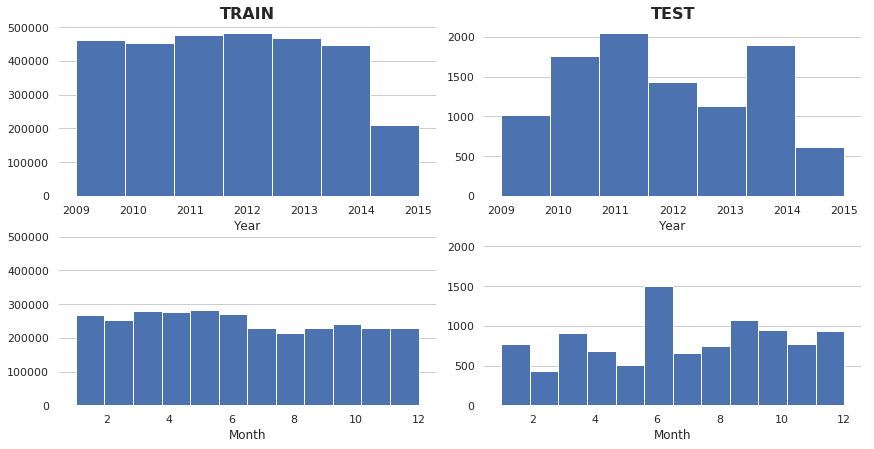

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,6), sharey= 'col')
fig.tight_layout()
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='16')
ax[0,1].set_title('TEST', fontweight='bold', fontsize='16')

# By year:
plot_hist(train.pickup_datetime.dt.year,0,0,xlabel='Year')
plot_hist(test.pickup_datetime.dt.year,0,1,xlabel='Year')

# By month:
plot_hist(train.pickup_datetime.dt.month,1,0, bins_=12, xlabel='Month')
plot_hist(test.pickup_datetime.dt.month,1,1,bins_=12, xlabel='Month')



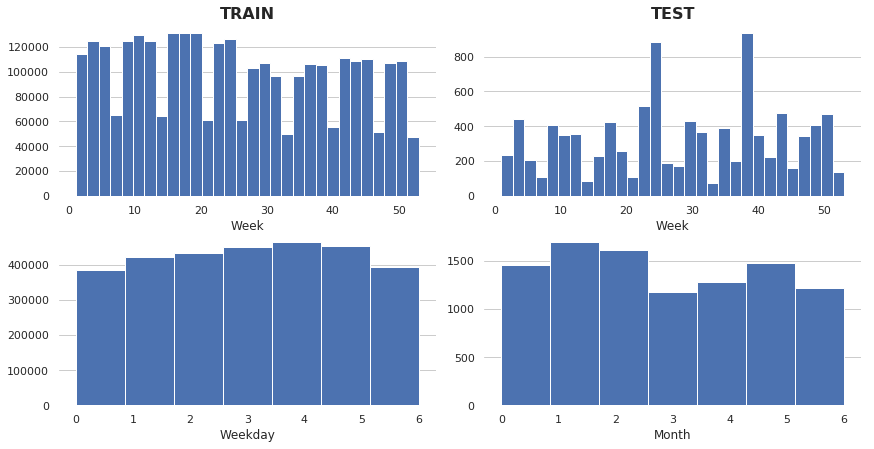

In [13]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.tight_layout()
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='16')
ax[0,1].set_title('TEST', fontweight='bold', fontsize='16')

# By year:
plot_hist(train.pickup_datetime.dt.week,0,0,bins_ = 30 ,xlabel='Week')
plot_hist(test.pickup_datetime.dt.week,0,1,bins_ = 30 ,xlabel='Week')

# By month:
plot_hist(train.pickup_datetime.dt.dayofweek,1,0, bins_=7, xlabel='Weekday')
plot_hist(test.pickup_datetime.dt.dayofweek,1,1,bins_=7, xlabel='Month')


Look for NaN values

In [14]:
train.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    23
dropoff_latitude     23
passenger_count       0
dtype: int64

In [15]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

since missing data has to do with geographic data (and they are so few) we can just drop them

In [16]:
print('Old size: %d' % len(train))
train = train.dropna()
print('New size: %d' % len(train))

Old size: 3000000
New size: 2999977


## Fare_amount
Note that there are some negative values for fare amount. We will pretty much drop them, as well as very absurd positive values, which we set to be any fare >100.



In [0]:
print('fare min: {} USD\nfare max: {} USD\nfare median: {} USD'.format(train.fare_amount.min(), train.fare_amount.max(), train.fare_amount.median()))

fare min: -62.0 USD
fare max: 1273.31 USD
fare median: 8.5 USD


The details of pricing of taxi rides in NYC can be found [here](https://www.numbeo.com/taxi-fare/in/New-York). We see that fares start at  *2.5 USD* charging *1.79 USD* for any additional kilometer (along with other parameters). In this sense we can filter data with fares lower than this threshold. The following histogram already shows the region that we consider for the `fare_amount` feature.

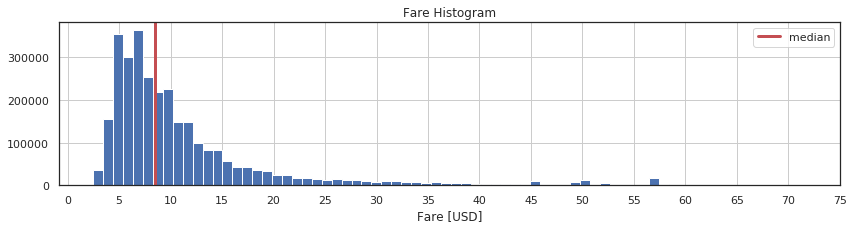

In [17]:
# plot histogram of fare
# train[(train.fare_amount<100)].fare_amount.hist(bins=100, figsize=(14,3))
train[(train.fare_amount<70) & (train.fare_amount> 2.5)].fare_amount.hist(bins=70, figsize=(14,3))
plt.xlabel('Fare [USD]')
plt.axvline(x=train[(train.fare_amount<70) & (train.fare_amount> 2.5)].fare_amount.median()
, c = 'r', label = 'median', linewidth = 3)
plt.legend()
plt.xticks([x for x in range(80) if x% 5 == 0])
plt.title('Fare Histogram');

In [18]:
train[(train.fare_amount<70) & (train.fare_amount> 2.5)].fare_amount.median()


8.5

## Geographical data
Let us look at data concerning the positions of pickup and dropoff. We are looking for any null value such as NaNs, or locations that do not correspond to the NY area.

We can also take a look at the histogram of pickups and dropoff locations. This will give us an idea on how to filter data for the modeling part.

By trying to plot a simple histogram of the `pickup_latitude` column we see that most of the values are concentred in a small region. More precisely, there are latitude values way off the ones for NY. 
To see this more carefully we plot several histograms (already focusing in the region of interest) that compare the train and test datasets. 



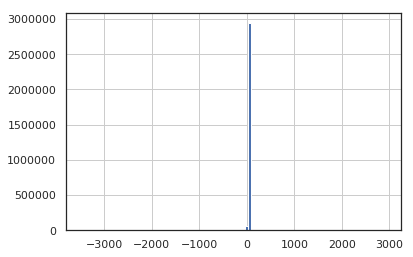

In [19]:
train.pickup_latitude.hist(bins=100)

[]

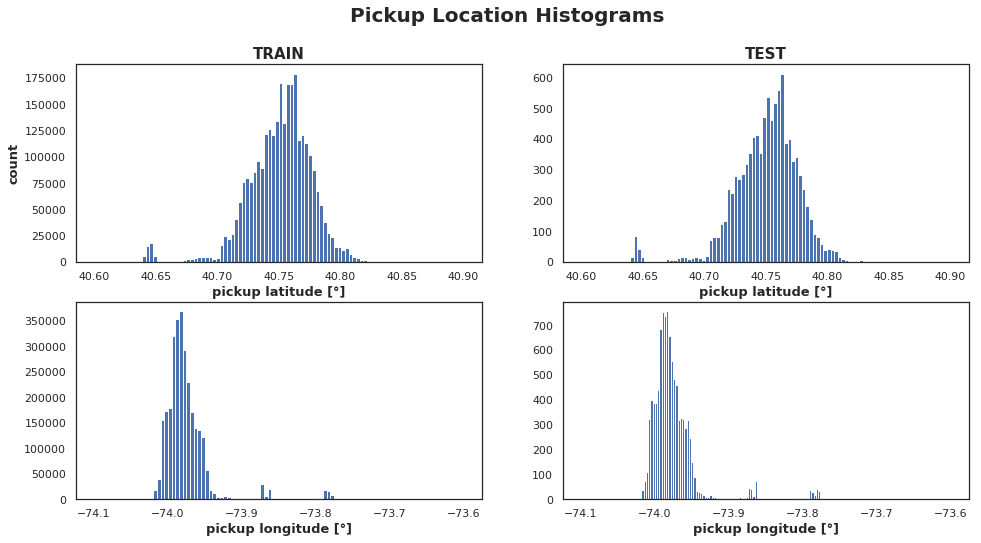

In [20]:
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex = 'row')
# fig.tight_layout() 
fig.suptitle('Pickup Location Histograms', fontweight = 'bold', fontsize='20')
ax[0,0].hist(train.pickup_latitude[(train.pickup_latitude> 40.6) & (train.pickup_latitude< 40.9)], bins =100)
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='15')
ax[0,0].set_xlabel('pickup latitude [°]', fontweight='bold', fontsize='13')
ax[0,0].set_ylabel('count', fontweight='bold', fontsize='13')

ax[0,1].hist(test.pickup_latitude[(test.pickup_latitude> 40.6) & (test.pickup_latitude< 40.9)], bins =100)
ax[0,1].set_xlabel('pickup latitude [°]', fontweight='bold', fontsize='13')
ax[0,1].set_title('TEST', fontweight='bold', fontsize='15')

ax[1,0].hist(train.pickup_longitude[(train.pickup_longitude> -74.1) & (train.pickup_longitude<-73.6)], bins =100)
ax[1,0].set_xlabel('pickup longitude [°]', fontweight='bold', fontsize='13')
# ax[1,0].set_ylabel('count', fontweight='bold', fontsize='13')

# ax[0,1].set_ylabel('count', fontweight='bold', fontsize='13')
ax[1,1].hist(test.pickup_longitude[(test.pickup_longitude> -74.1) & (test.pickup_longitude<-73.6)], bins =100)
ax[1,1].set_xlabel('pickup longitude [°]', fontweight='bold', fontsize='13')
# ax[1,1].set_ylabel('count', fontweight='bold', fontsize='13')
fig.legends

Both distributions seem very similar. This strongly suggests that the dataset was randomly shuffled before performing the train/test split. By having a shuffled train set, we can sample the dataset without losing too much information about the whole population statistics. This is, we can use less data and hope to have a good representative of the entire dataset. This is important since the entire dataset is difficult to handle, as a consequence to perform Feat. Engineering would be very costly.

[]

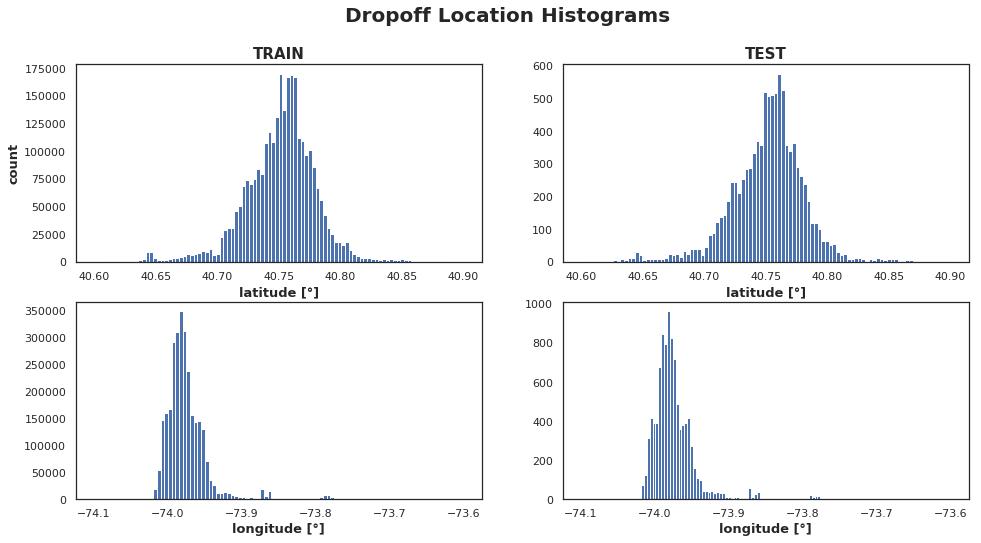

In [21]:
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex = 'row')
# fig.tight_layout() 
fig.suptitle('Dropoff Location Histograms', fontweight = 'bold', fontsize='20')
ax[0,0].hist(train.dropoff_latitude[(train.dropoff_latitude> 40.6) & (train.dropoff_latitude< 40.9)], bins =100)
ax[0,0].set_title('TRAIN', fontweight='bold', fontsize='15')
ax[0,0].set_xlabel('latitude [°]', fontweight='bold', fontsize='13')
ax[0,0].set_ylabel('count', fontweight='bold', fontsize='13')

ax[0,1].hist(test.dropoff_latitude[(test.dropoff_latitude> 40.6) & (test.dropoff_latitude< 40.9)], bins =100)
ax[0,1].set_xlabel('latitude [°]', fontweight='bold', fontsize='13')
ax[0,1].set_title('TEST', fontweight='bold', fontsize='15')

ax[1,0].hist(train.dropoff_longitude[(train.dropoff_longitude> -74.1) & (train.dropoff_longitude<-73.6)], bins =100)
ax[1,0].set_xlabel('longitude [°]', fontweight='bold', fontsize='13')
# ax[1,0].set_ylabel('count', fontweight='bold', fontsize='13')

# ax[0,1].set_ylabel('count', fontweight='bold', fontsize='13')
ax[1,1].hist(test.dropoff_longitude[(test.dropoff_longitude> -74.1) & (test.dropoff_longitude<-73.6)], bins =100)
ax[1,1].set_xlabel('longitude [°]', fontweight='bold', fontsize='13')
# ax[1,1].set_ylabel('count', fontweight='bold', fontsize='13')
fig.legends

We see that both the train and test sets have a similar distribution. Furthermore, We can spot a couple of special locations that are off the main NY area. They may correspond to airports or special locations. To have a better sense of data, let us plot the pickup and dropoff points on an actual map.

Finally, to handle the values that do not correspond to the NY area, we will use the min and max values in the test set, in that way we do not throw everything off. This could be considered a data leakage since we are using information about the test set to shape the train set. Data leakages are common practice in the competitive data science community.

In [22]:
# minimum and maximum longitude test set
long_bb = min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())
# minimum and maximum latitude test
lat_bb = min(test.pickup_latitude.min(), test.dropoff_latitude.min()), max(test.pickup_latitude.max(), test.dropoff_latitude.max())
BB = long_bb + lat_bb
BB

(-74.263242, -72.986532, 40.568973, 41.709555)

We will use the above Bounding Box to select relevant data only. Now, let us visualize pickup and dropoff points on an actual NYC map, to have a visual idea of the distribution of trips. From here, special spots such as Airports can be identified.

In [0]:
 

# function to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, airports = False):
    if airports == False:
      fig, ax = plt.subplots(1, 2, figsize=(16,10))
      ax[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='g', s=s)
      ax[0].set_xlim((BB[0], BB[1]))
      ax[0].set_ylim((BB[2], BB[3]))
      ax[0].set_title('Pickup locations')
      ax[0].set_xlabel('Longitude')
      ax[0].set_ylabel('Latitude')
      ax[0].imshow(nyc_map, zorder=0, extent=BB)

      ax[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
      ax[1].set_xlim((BB[0], BB[1]))
      ax[1].set_ylim((BB[2], BB[3]))
      ax[1].set_title('Dropoff locations')
      ax[1].set_xlabel('Longitude')
      ax[1].set_ylabel('Latitude')
      ax[1].imshow(nyc_map, zorder=0, extent=BB)
    
    else:
      # airport locations
      jfk = (-73.7822222222, 40.6441666667) # JFK
      nwrk = (-74.175, 40.69) # Newark Liberty
      lgr = (-73.87, 40.77) # La guardia
      
      fig, ax = plt.subplots(1, 2, figsize=(16,10))
      ax[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='g', s=s)
      ax[0].scatter(jfk[0], jfk[1], marker='o', facecolors='none', edgecolors='r', linewidths =2)
      ax[0].scatter(nwrk[0], nwrk[1], marker='o', facecolors='none', edgecolors='r', linewidths =2)
      ax[0].scatter(lgr[0], lgr[1], marker='o', facecolors='none', edgecolors='r', linewidths =2)
      ax[0].set_xlim((BB[0], BB[1]))
      ax[0].set_ylim((BB[2], BB[3]))
      ax[0].set_title('Pickup locations')
      
      ax[0].set_xlabel('Longitude')
      ax[0].set_ylabel('Latitude')
      ax[0].imshow(nyc_map, zorder=0, extent=BB)

      ax[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
      ax[1].scatter(jfk[0], jfk[1], marker='o', facecolors='none', edgecolors='r', linewidths =2)
      ax[1].scatter(nwrk[0], nwrk[1], marker='o', facecolors='none', edgecolors='r', linewidths =2)
      ax[1].scatter(lgr[0], lgr[1], marker='o', facecolors='none', edgecolors='r', linewidths =2)
      ax[1].set_xlim((BB[0], BB[1]))
      ax[1].set_ylim((BB[2], BB[3]))
      ax[1].set_title('Dropoff locations')
      ax[1].set_xlabel('Longitude')
      ax[1].set_ylabel('Latitude')
      ax[1].imshow(nyc_map, zorder=0, extent=BB)
      

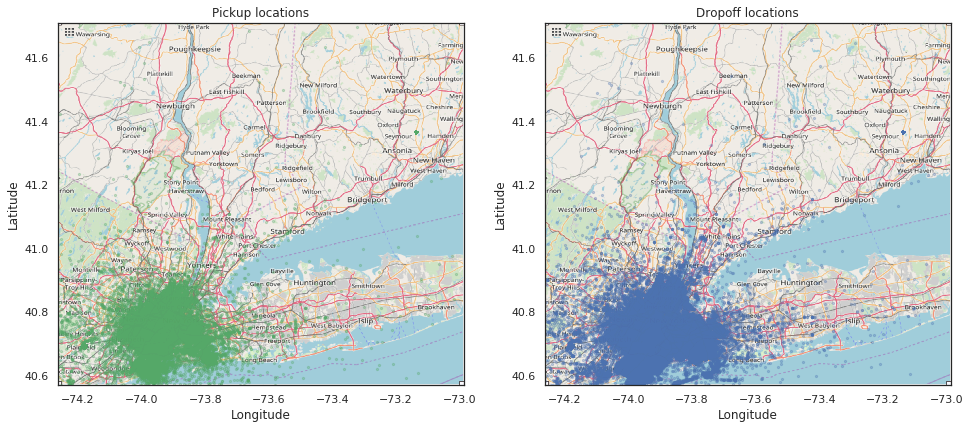

In [25]:
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
plot_on_map(train, BB, nyc_map, s=5, alpha=0.3)


Let us have a closer look, this time highlighting the locations of airports. 

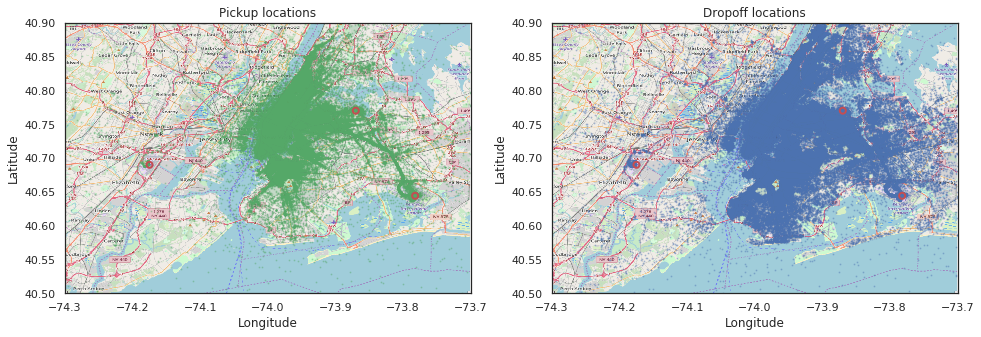

In [26]:
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')
plot_on_map(train, BB_zoom, nyc_map_zoom, s=1, alpha = 0.3, airports = True)


## Passenger_count
Let us look at the feature that counts the number of passengers at each ride. The max value is non-sense. Also, rides with 0 passengers should not be considered.

In [27]:
print('passenger min: {}\npassenger max: {}\npassenger median: {}'.format(train.passenger_count.min(), train.passenger_count.max(), train.passenger_count.median()))

passenger min: 0
passenger max: 208
passenger median: 1.0


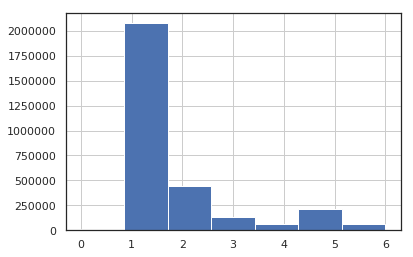

In [28]:
train[train.passenger_count <= 7].passenger_count.hist(bins =7)

## The cut
Considering all the above insights on data, we perform a **cut** in the train file, as follows:

In [29]:
train_cut = train[((train.pickup_longitude >= BB[0]) & (train.pickup_longitude <= BB[1])) 
         & ((train.pickup_latitude >= BB[2]) & (train.pickup_latitude <= BB[3])) 
         & ((train.dropoff_longitude >= BB[0]) & (train.dropoff_longitude <= BB[1])) 
         & ((train.dropoff_latitude >= BB[2]) & (train.dropoff_latitude <= BB[3])) 
         & (train.fare_amount > 2.5) & (train.fare_amount < 100) & (train.passenger_count > 0) & (train.passenger_count < 5)] #& (train.distance > 0.2)]
print('Proportion of Data lost: {0:.3f}%'.format( (train.shape[0] - train_cut.shape[0])/ train.shape[0] * 100))

Proportion of Data lost: 11.841%


# Feature Engineering
---
In this section we intend to expand our dataset by adding aritificial features. This can be done in many ways (for this particular dataset), and ultimately dependes on the creativity and prior knowledge of the DS. In this case, we will not perform a very sophisticated process, but rather something simple that cann enrich our dataset. 

As an starting point we consider:
*  *geographic*  distance between pickup and dropoff. 
* pickup hour (bucketized)
* weekday --> one hot encoded

For later:
* direction of the trip (E-W and N-S)
* grid position on the map (you could use a 10x10 grid)
* Holidays
* From airport / To airport (for fixed fare trips)

We want to include the geographical distance between the pickup and dropoff points as a new feature. There several ways one can implement this in python. Here we compare two and select the one that performs better in terms of time. In one case we use the `distance` method of the *geopy* library. We then compare the performance of this computation with a calculation of the distance *by hand*.

In [0]:
# calculating the distance between the two points (pickup and dropoff) in km
def distance(lat1, lon1, lat2, lon2, norm = 2):
  '''
    Calculates the distance between two points: (lat1,lon1) and (lat2,lon2)
    norm: 1 --> 'Manhattan'
          2 --> 'haversine'
  '''
  if norm == 1:
    distance = np.abs(lat2 - lat1) + np.abs(lon2 - lon1)
  elif norm == 2:
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    distance = 12742 * asin(sqrt(a)) #2*R*asin
  return distance 

  

In [0]:
# import the module
from geopy.distance import geodesic

Compare both calculations on the first row. 

In [32]:
dist1 = geodesic((train.iloc[0].pickup_latitude,train.iloc[0].pickup_longitude), (train.iloc[0].dropoff_latitude,train.iloc[0].dropoff_longitude)).km
dist2 = distance(train.iloc[0].pickup_latitude,train.iloc[0].pickup_longitude,train.iloc[0].dropoff_latitude,train.iloc[0].dropoff_longitude)
print('geopy:\t{0:.3f} km\nfunc:\t{1:.3f} km'.format(dist1, dist2))

geopy:	1.030 km
func:	1.031 km


Both results differ at the meters level. Let's compare their performance

In [33]:
%timeit train_cut[:100].apply(lambda row: geodesic((row.pickup_latitude, row.pickup_longitude), (row.dropoff_latitude, row.dropoff_longitude)).km, axis =1)


10 loops, best of 3: 44.3 ms per loop


In [34]:
%timeit train_cut[:100].apply(lambda row: distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude, norm =2), axis =1)


100 loops, best of 3: 15.6 ms per loop


Our *hand-writte* function performs better than the geopy method. So we stick to our function. Now we are ready to construct a dataframe with new features. We include:
* The geographic distance between the pickup and dropoff points.
* The day hour, this feature could be made into buckets as well.
* Weekdays are included in  one-hot form.
* We discretize the NY area into a grid of size $N \times N$, where $N$ is the number of buckets.
* Discrete and continuous displacement along the x and y directions are also included as features. The intuition behind these features is that they give information about the direction of the trip (E-W) and (N-S). Also, the *manhattan* distance is a function of these values.

In [0]:
def add_feats(df, norm = 1, bins = 50):
  '''
  Input:  pandas dataframe
  Output: dataframe with added features
  '''
#   df['distance'] = df.apply(lambda row: geodesic((row.pickup_latitude, row.pickup_longitude), (row.dropoff_latitude, row.dropoff_longitude)).km, axis =1)
  df['distance'] = df.apply(lambda row: distance(row.pickup_latitude, row.pickup_longitude, row.dropoff_latitude, row.dropoff_longitude, norm ), axis =1)
  df['hour'] = df.pickup_datetime.dt.hour
#   df['day'] = df.pickup_datetime.dt.day
#   df['month'] = df.pickup_datetime.dt.month
#   df['weekday'] = df.pickup_datetime.dt.weekday
  weekday =pd.get_dummies(df.pickup_datetime.dt.weekday)
  weekday.columns = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
  df = pd.concat([df,weekday], axis = 1)
  
  # Discretization of the Ny area into a grid of 
  df['picklat_b'] = pd.cut(df.pickup_latitude, bins , labels = False)
  df['picklon_b'] = pd.cut(df.pickup_longitude, bins, labels = False)
  df['droplat_b'] = pd.cut(df.dropoff_latitude, bins, labels = False)
  df['droplon_b'] = pd.cut(df.dropoff_longitude, bins, labels = False)
  # discrete displacement both x- and y-wise 
  df['lon_disp_b'] = df.picklon_b - df.droplon_b
  df['lat_disp_b'] = df.picklat_b - df.droplat_b

  # continuous displacement both x- and y-wise
  df['lon_disp'] = df.pickup_longitude - df.dropoff_longitude
  df['lat_disp'] = df.pickup_latitude - df.dropoff_latitude

  return df

### Attention: 
The following cell contains processing of data and it takes quite a few to complete running. As an alternative we suggest to skip this cell and go straight to the Modeling section where we load a previously processed dataset.

In [36]:
# it takes around 11 min for 5M rows
start_time = time.time()
train_cut = add_feats(train_cut, norm = 2)
print("Train\n--- {} seconds ---".format(time.time() - start_time))
test_cut = add_feats(test, norm = 2)
print("Test\n--- {} seconds ---".format(time.time() - start_time))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Train
--- 392.1885824203491 seconds ---
Test
--- 393.6569194793701 seconds ---


Let us have a look at some of the newly added features. First, we will see if performing the operations in the `add_feats` function has created null values.





In [37]:
train_cut.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
hour                 0
mon                  0
tue                  0
wed                  0
thu                  0
fri                  0
sat                  0
sun                  0
picklat_b            0
picklon_b            0
droplat_b            0
droplon_b            0
lon_disp_b           0
lat_disp_b           0
lon_disp             0
lat_disp             0
dtype: int64

Text(0, 0.5, 'Fare [USD]')

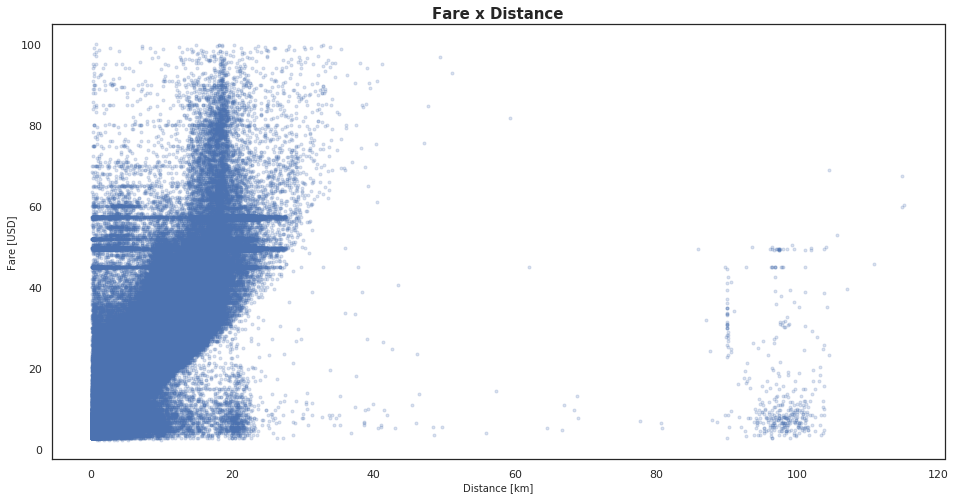

In [40]:

# fig, ax = plt.subplots(1, 2, figsize = (20,10))
plt.figure(figsize = (16,8))
plt.scatter( x='distance', y='fare_amount', data = train_cut, alpha =0.2, marker = '.')
plt.title('Fare x Distance', fontdict={'fontweight': 'bold', 'fontsize': '15'})
plt.xlabel('Distance [km]', fontdict={'fontsize': '10'})
plt.ylabel('Fare [USD]', fontdict={'fontsize': '10'})
# ax[1].scatter()

From the above figure we can draw a few insights.
* There are lots of trips with $\text{distance} = 0 $. These rows will be discarted.
* We can also notice the presence of horizontal lines, indicating the existence of trips with fixed fare but viarable distance. These could stand for fixed-fare trips, like the ones related to airports.


In [39]:
# We will drop the rows with distance>0.2 (200m)
print('percentage of removed data: {0:.3f}%'.format(((train_cut.shape[0]-train_cut.query('distance > 0.2').shape[0])/train_cut.shape[0])* 100))
train_cut.query('distance > 0.2', inplace = True)

percentage of removed data: 1.625%


Save this dataframe as a pickle file so we can load it later, and save computation time.

In [0]:
train_cut.to_pickle('./train_cut.pkl')
test_cut.to_pickle('./test_cut.pkl')

# Data Visualization
---
In this section, we generate some of the visualizations that we use in the presentation.

In [0]:
def plot_hires(df = train_cut, BB = BB , data_size = None , figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
      fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if data_size == None:
      ax.scatter(df.pickup_longitude, df.pickup_latitude, c=c[0], s=0.01, alpha=0.5)
      ax.scatter(df.dropoff_longitude, df.dropoff_latitude, c=c[1], s=0.01, alpha=0.5)
    else:
      ax.scatter(df[:data_size].pickup_longitude, df[:data_size].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
      ax.scatter(df[:data_size].dropoff_longitude, df[:data_size].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)
    
    ax.set_xlim((BB[0], BB[1]))
    ax.set_ylim((BB[2], BB[3]))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

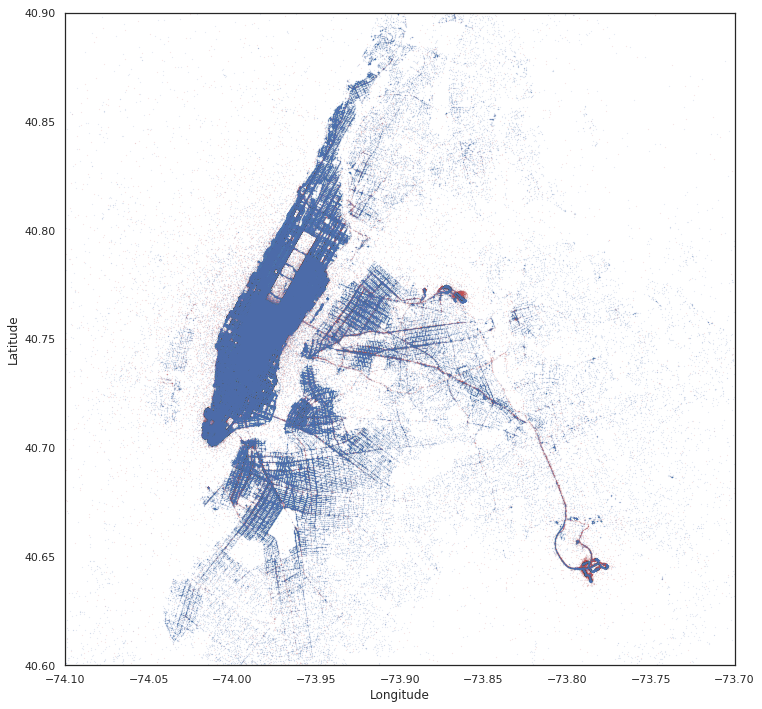

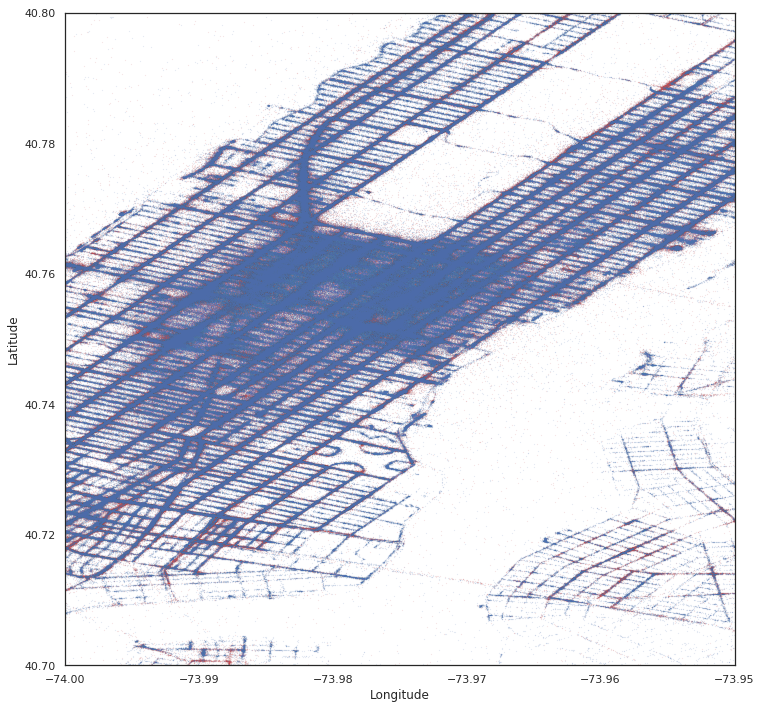

In [43]:
plot_hires(train_cut, BB = (-74.1, -73.7, 40.6, 40.9))
plot_hires(train_cut, BB =(-74, -73.95, 40.7, 40.8))

Let's make density plots using a grid

In [0]:
def heat_plot(df, bins= 100, BB =(-74.3, -73.7, 40.5, 40.9), figsize=(12,12), kind = 'pick', alpha = 0.8, date = None, day = None):
  '''
  A function for generation of discretized density plots
  '''
  # cut the dataframe
  dens_df = df[((train.pickup_longitude >= BB[0]) & (train.pickup_longitude <= BB[1])) 
         & ((train.pickup_latitude >= BB[2]) & (train.pickup_latitude <= BB[3])) 
         & ((train.dropoff_longitude >= BB[0]) & (train.dropoff_longitude <= BB[1])) 
         & ((train.dropoff_latitude >= BB[2]) & (train.dropoff_latitude <= BB[3]))]
  title_date = ' '
# Daylight period
  if day == 'early':
    dens_df = dens_df[(dens_df.pickup_datetime.dt.hour >= 2 ) & (dens_df.pickup_datetime.dt.hour < 6 )]
    title_date = '2am to 6am'
    
  if day == 'morning':
    dens_df = dens_df[(dens_df.pickup_datetime.dt.hour >= 6 ) & (dens_df.pickup_datetime.dt.hour < 10 )]
    title_date = '6am to 10am'
    
  if day == 'noon':
    dens_df = dens_df[(dens_df.pickup_datetime.dt.hour >= 10 ) & (dens_df.pickup_datetime.dt.hour < 14 )]
    title_date = '10am to 2pm'
    
  if day == 'anoon':
    dens_df = dens_df[(dens_df.pickup_datetime.dt.hour >= 14 ) & (dens_df.pickup_datetime.dt.hour < 18 )]
    title_date = '2pm to 6pm'
  
  if day == 'night':
    dens_df = dens_df[(dens_df.pickup_datetime.dt.hour >= 18 ) & (dens_df.pickup_datetime.dt.hour < 22 )]
    title_date = '6pm to 10pm'
  if day == 'latenight':
    dens_df = dens_df[(dens_df.pickup_datetime.dt.hour >= 22 ) | (dens_df.pickup_datetime.dt.hour < 2 )]
    title_date = '10pm to 2am'
  
  #   Date filtering
  if date == 'halloween':
    dens_df = dens_df[((dens_df.pickup_datetime.dt.day == 31) & (dens_df.pickup_datetime.dt.month == 10) & (dens_df.pickup_datetime.dt.hour > 18)) 
          | ((dens_df.pickup_datetime.dt.day == 1) & (dens_df.pickup_datetime.dt.month == 11)  & (dens_df.pickup_datetime.dt.hour < 2))]
    title_date = 'Halloween'
    
  if date == 'xmas':
    dens_df = dens_df[((dens_df.pickup_datetime.dt.day == 24) & (dens_df.pickup_datetime.dt.month == 12) & (dens_df.pickup_datetime.dt.hour > 18)) 
          | ((dens_df.pickup_datetime.dt.day == 25) & (dens_df.pickup_datetime.dt.month == 12)  & (dens_df.pickup_datetime.dt.hour < 23))]
    title_date = 'christmas'
  
  if date == 'newyear':
    dens_df = dens_df[((dens_df.pickup_datetime.dt.day == 31) & (dens_df.pickup_datetime.dt.month == 12) & (dens_df.pickup_datetime.dt.hour > 18)) 
          | ((dens_df.pickup_datetime.dt.day == 1) & (dens_df.pickup_datetime.dt.month == 1)  & (dens_df.pickup_datetime.dt.hour < 10))]
    title_date = 'New Year'
    
  if kind == 'pick':
    heatmap, xedges, yedges = np.histogram2d(dens_df.pickup_longitude, dens_df.pickup_latitude, bins=bins) 
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    title = 'Pickup' 
  
  elif kind == 'drop':
    heatmap, xedges, yedges = np.histogram2d(dens_df.dropoff_longitude, dens_df.dropoff_latitude, bins=bins) 
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    title = 'Dropoff'

  # Plot heatmap
  plt.clf()
  plt.figure(figsize = figsize)
  nyc_map= plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')
  plt.imshow(nyc_map, zorder=0, extent=(-74.3, -73.7, 40.5, 40.9)
)
  plt.title(title_date+ ' '+ title + ' ' + 'Heatmap')
  plt.ylabel('Latitude')
  plt.xlabel('Longitude')
  plt.imshow(np.log1p(heatmap).T, 
             extent=extent, 
             origin='lower',
             alpha = alpha,
             interpolation = None,
            )
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

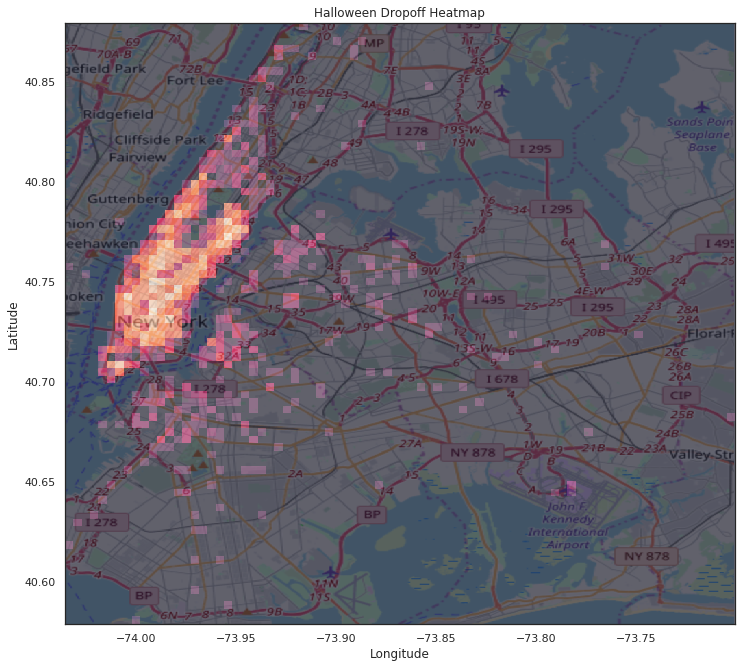

In [63]:
heat_plot(train_cut, bins=80, BB = (-74.3, -73.7, 40.5, 40.9), kind ='drop', alpha = 0.6, date= 'halloween' )


# Modeling
---
In this section we start the construction of simple models for fare prediction. Which we cast as a regression problem.

## Train/Validation split
We will split the train set into two datasets: Train and validation

The given test dataset will be held out for final scoring.

In [0]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

In [0]:
# Run for loading the previously processed  train_cut dataframe
# Uncomment and run this cell to load the processed data
# train_cut = pickle.load(open("train_cut.pkl", "rb"))
# train_cut = train_cut.loc[:,~train_cut.columns.duplicated()]

In [0]:
# Uncomment and run this cell to see the head of the dataframe
# train_cut.head().T

In [0]:
# Select features for modeling and perform the test/validation split

cols = ['pickup_longitude',
       'pickup_latitude', 
       'dropoff_longitude',
       'dropoff_latitude',
       'passenger_count', 
       'distance', 
       'hour', 
       'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 
       'picklat_b', 
       'picklon_b', 
       'droplat_b', 
       'droplon_b',
       'lon_disp_b', 
       'lat_disp_b', 
       'lon_disp', 
       'lat_disp']
X_train, X_test, y_train, y_test = train_test_split(train_cut.drop('fare_amount', axis=1)[cols],
                                                    train_cut['fare_amount'], test_size=0.20)

## Linear Model (Benchmarking)

We will start with a linear model for a starter. This will serve as a benchmark model to compare the performance of more complex models

In [0]:

lin_model = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))

lin_model.fit(X_train, y_train)

y_train_pred = lin_model.predict(X_train)
y_test_pred = lin_model.predict(X_test)

# lin_model.fit(X_train[['passenger_count','distance', 'hour']], y_train)

# y_train_pred = lin_model.predict(X_train[['passenger_count','distance', 'hour']])
# y_test_pred = lin_model.predict(X_test[['passenger_count','distance', 'hour']])

We use the RMSE score for validation of our model (Kaggle)


In [0]:
print('LINEAR MODEL --- RMSE scores\ntrain: {}\ntest: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred)),
np.sqrt(mean_squared_error(y_test, y_test_pred))))


LINEAR MODEL --- RMSE scores
train: 4.6494525184007145
test: 4.656084499877911


In [0]:
# Coefficients
list(zip(cols, lin_model.steps[1][1].coef_))

[('pickup_longitude', -44620320704935.91),
 ('pickup_latitude', -2504982512543.535),
 ('dropoff_longitude', 43000980874771.85),
 ('dropoff_latitude', 2804977455157.3105),
 ('passenger_count', 0.07334954384317151),
 ('distance', 7.5523209435874525),
 ('hour', 0.06563773497324371),
 ('mon', -311161767691.2402),
 ('tue', -322740643253.66144),
 ('wed', -326574679434.3855),
 ('thu', -331369949918.5754),
 ('fri', -335556259903.90234),
 ('sat', -332843350939.34814),
 ('sun', -313459244623.35156),
 ('picklat_b', 560794685345.7128),
 ('picklon_b', 10778371484789.834),
 ('droplat_b', -650039488509.1238),
 ('droplon_b', -10320814151226.266),
 ('lon_disp_b', -12895241728925.654),
 ('lat_disp_b', -680921196283.7882),
 ('lon_disp', 53190832818777.984),
 ('lat_disp', 2941768328147.8296)]

### Generate Kaggle Submission
Let's generate the kaggle submission file for the linear regression

In [0]:
lin_predicts = lin_model.predict(test_cut[cols])

In [0]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': lin_predicts},
    columns = ['key', 'fare_amount'])
submission.to_csv('lin_submission.csv', index = False)

In [0]:
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.001143
1,2015-01-27 13:08:24.0000003,10.202315
2,2011-10-08 11:53:44.0000002,5.251631
3,2012-12-01 21:12:12.0000002,7.594893
4,2012-12-01 21:12:12.0000003,14.227705


## Gradient Boosted Decision Trees (XGBoost)
Next, we construct a Boosted Decision Tree model. The best paremeters were found using Bayesian Optimization.There is no need to run the cells corresponding to the optimization, so we commented them. However, they can be run and we recomnd to grapb a cup of coffee to wait unitl the procedure is finished.

In [0]:
# !pip install bayesian-optimization


In [0]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

# Uncomment the following line for Bayesian Optimization
# from bayes_opt import BayesianOptimization

def plot_features(booster, figsize):    
  fig, ax = plt.subplots(1,1,figsize=figsize)
  return plot_importance(booster=booster, ax=ax)



In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


The next cell was run to obtain the best parameters for the XGBoost algorithm.
We recommend to use the Colab enviroment if willing to run the cell.

In [0]:
# A function to evaluate the xgb regressor 

# def xgb_evaluate(max_depth, gamma, colsample_bytree):
#   params = {'eval_metric': 'rmse',
#             'max_depth': int(max_depth),
#             'subsample': 0.8,
#             'eta': 0.1,
#             'gamma': gamma,
#             'colsample_bytree': colsample_bytree}
#   cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=3)    

#   # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
#   return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [0]:
# Run this cell to perform BO

# start_time = time.time()
# xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
#                                              'gamma': (0, 1),
#                                              'colsample_bytree': (0.3, 0.9)})
# # Use the expected improvement acquisition function to handle negative numbers
# # Optimally needs quite a few more initiation points and number of iterations
# xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')
# print("--- %s seconds ---" % (time.time() - start_time))


|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -3.829    |  0.4186   |  0.06302  |  3.528    |
|  2        | -3.622    |  0.7204   |  0.2018   |  6.843    |
|  3        | -3.726    |  0.7262   |  0.2292   |  4.303    |
|  4        | -3.59     |  0.9      |  1.0      |  7.0      |
|  5        | -3.653    |  0.3      |  1.0      |  6.456    |
|  6        | -3.623    |  0.9      |  1.0      |  6.527    |
|  7        | -3.807    |  0.9      |  1.0      |  3.0      |
|  8        | -3.623    |  0.8965   |  0.9629   |  6.999    |
--- 3044.310591697693 seconds ---


In [0]:
params = {'max_depth': 7.0, 'gamma': 0.2018,  'max_delta_step': 10.0, 'subsample': 0.4, 'colsample_bytree': 0.9}
params['max_depth'] = int(params['max_depth'])


We now train the XGBoost algorithm on the train dataset and evaluate on the held-out test dataset. The trained model is then evaluated both in the train and test set using the RMSE metric. 

In [0]:
start_time = time.time()
# Train a model with the hyperparameters we obtained in the search
model_xgb = xgb.train(params, dtrain, num_boost_round=250)
print("--- %s seconds ---" % (time.time() - start_time))

# Predict on testing and training set
y_pred_xgb = model_xgb.predict(dtest)
y_train_pred_xgb = model_xgb.predict(dtrain)

# Report testing and training RMSE
print('RMSE train: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))))
print('RMSE test: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_xgb))))


--- 968.8905916213989 seconds ---
RMSE train: 3.0357339014975646
RMSE test: 3.249242577447787


The F-score sums up the number of times a given feature is split. Comparing this quantity for each feature is usually interpreted as a *Feature Importance* plot.

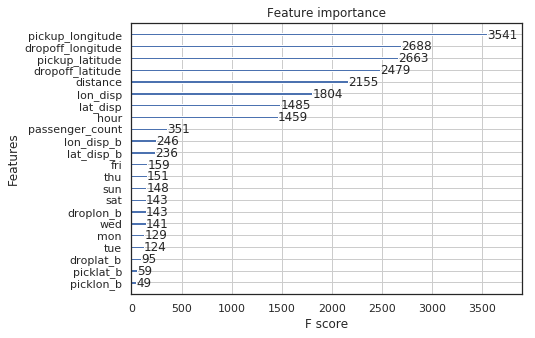

In [0]:
plot_features(model_xgb, (7,5))


Serialize the xgboost model as a pickle file for re-use.

In [0]:
# save model to file
pickle.dump(model_xgb, open("xgb.pickle.dat", "wb"))


In [0]:
# Uncomment and run this cell to load the xgb model.

# loaded_model = pickle.load(open("xgb.pickle.dat", "rb"))

### Generate the predictions for kaggle

In [0]:
dtest_final = xgb.DMatrix(test_cut[cols])

In [0]:
xgb_predicts = model_xgb.predict(dtest_final) 

In [0]:

xgb_submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': xgb_predicts},
    columns = ['key', 'fare_amount'])
xgb_submission.to_csv('xgb_submission.csv', index = False)

In [0]:
xgb_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.099486
1,2015-01-27 13:08:24.0000003,10.310859
2,2011-10-08 11:53:44.0000002,4.936438
3,2012-12-01 21:12:12.0000002,7.827735
4,2012-12-01 21:12:12.0000003,13.404600


## kNN Regression
As the last model we consider a k-Nearest Neighbors regression. The number of neighbors was selected using GridSearch and Cross Validation, there is no need to run the cell corresponding to this procedure. In the case the reader wants to run the GridSearch we advise for the use of Google's Colab enviroment.


In [0]:
#import required packages
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

We perform a GridSearch together with Cross-Validation with 5 splits to find the best parameters for our model.

In [0]:
# GridSearch
start_time = time.time()
params = {'n_neighbors':[12,15,20,25,30]}

knn_model =  neighbors.KNeighborsRegressor()
model = GridSearchCV(knn_model, params, cv=5)
model.fit(X_train[:100000],y_train[:100000])
print("--- %s seconds ---" % (time.time() - start_time))
model.best_params_


--- 183.74576544761658 seconds ---


{'n_neighbors': 25}

In [0]:
# knn_model = Pipeline((
#         ('standard_scaler', StandardScaler()),
#         ('knn', neighbors.KNeighborsRegressor(),
#     ))
start_time = time.time()
knn_model = neighbors.KNeighborsRegressor(n_neighbors= 15, n_jobs=-1)
knn_model.fit(X_train, y_train)
print('--- {0:.3f} seconds for training---'.format(time.time() - start_time))
y_train_pred_k = knn_model.predict(X_train)
y_test_pred_k = knn_model.predict(X_test)
print('--- {0:.3f} seconds for prediction---'.format(time.time() - start_time))

--- 1735.014 seconds for training---
--- 3780.533 seconds for prediction---


In [0]:
# Report testing and training RMSE
print('RMSE test: {}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred_k))))
print('RMSE train: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred_k))))

RMSE test: 3.4502229440257253
RMSE train: 3.242056723566817


# Final Remarks
The main difficulty about solving this problem might be the quantity of data. However, we show that we are able to construct predivitive models with less data that perform better than the average models at [Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/leaderboard). 

We construct and evaluate three predicitive models:
* a simple linear regression that is used as a Benchmark. 
* we then proceed to a Gradient Boosted Decision Tree. The best paremeters for this model were chosen using Bayesian Optimization, implemented [here](https://github.com/fmfn/BayesianOptimization).
* the last model consists on a k-NearestNeighbor regressor. In this case, the best number of neighbors is found using a Grid Search that is Cross-Validated, see the documentation. 


Among the three models, the XGBoost appears to be one that performs the best. However, further validation is required. The k-NN regressor model comes second in terms of performance on the test set. However, this algorithm is very slow and given the amount of data, might not be the best choice.
During the development of the models two major enhancements on the effectiveness of the models (measured in RMSE) where encountered:
* by including the distance feature, and
* by dropping the trips with distance = 0 

## For further development
The selection of the models based only on performance w.r.t. the Root Mean Square Error is not enough. An exhaustive implementation of **Statistical Significance Tests** is lacking.


If the intention is to pursue a better performance (for competitive purposes) we highlight some wasy we belive can improve the result:
* Use the whole Dataset. Although, we do not think the use of the entire dataset will readily improve the performance.
* Feature Engineering is the best place to look at. For instance, there are several pickup and dropoff points that lie on the sea, dropping these may translate in a performance increase. Somethng similar happened when dropping the trips with distance = 0.
* Special points as ariports seem to have a relation with the fare. There may be fixed fare trips departing or reaching these locations. Accounting for them may also increase the effectiveness of the models. 
* Including external datasets such as the temperature and precipitation rates could be correlated with an increase in taxi rides.
